In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import glob

In [31]:
#drive.mount("/content/drive")
baseUrl = '/content/drive/Shared drives/Analitica Predictiva'
os.chdir(baseUrl)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
dfCovid = pd.read_pickle('covid19.pkl')
dfCovid.shape

(624069, 21)

In [5]:
dfCovid.describe().T

,count,unique,top,freq
id_de_caso,624069,624069,63994,1
fecha_de_notificaci_n,624069,181,2020-07-27T00:00:00.000,12107
c_digo_divipola,624069,1023,11001,213631
ciudad_de_ubicaci_n,624069,949,Bogotá D.C.,213631
departamento,624069,37,Bogotá D.C.,213631
atenci_n,624069,6,Recuperado,469557
edad,624069,110,30,16739
sexo,624069,4,M,320545
tipo,624069,7,En estudio,592007
estado,624069,6,Leve,503555


In [6]:
dfCovid.tail(5)

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
624064,624105,2020-08-23T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Casa,31,M,En estudio,Asintomático,NaN,Asintomático,2020-08-28T00:00:00.000,NaN,2020-09-01T00:00:00.000,NaN,11,NaN,NaN,NaN,NaN
624065,624106,2020-08-28T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Casa,43,M,En estudio,Asintomático,NaN,Asintomático,2020-08-31T00:00:00.000,NaN,2020-09-01T00:00:00.000,NaN,11,NaN,NaN,NaN,NaN
624066,624107,2020-08-23T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Casa,74,F,En estudio,Asintomático,NaN,Asintomático,2020-08-29T00:00:00.000,NaN,2020-09-01T00:00:00.000,NaN,11,NaN,NaN,NaN,NaN
624067,624108,2020-08-27T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Casa,39,F,En estudio,Asintomático,NaN,Asintomático,2020-08-31T00:00:00.000,NaN,2020-09-01T00:00:00.000,NaN,11,NaN,NaN,NaN,NaN
624068,624109,2020-08-28T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Casa,35,F,En estudio,Asintomático,NaN,Asintomático,2020-08-31T00:00:00.000,NaN,2020-09-01T00:00:00.000,NaN,11,NaN,NaN,NaN,NaN


Se construye una caracteristica nueva **Fecha Infeccioso**, con la menor fecha posible entre: fecha de notificación, fecha de diagnóstico y fecha de inicio de sintomas. (Para los *Asintomático* en el FIS, se define una fecha 20991231 en una nueva columna **fis_cor** usada para la comparación)

In [33]:
dfCovid['fis_cor']=dfCovid['fis']
dfCovid.loc[dfCovid['fis']=='Asintomático','fis_cor']=pd.to_datetime('2099-12-31',format='%Y-%m-%d')
dfCovid['fis_cor'] = pd.to_datetime(dfCovid['fis_cor'].str.split('T',expand=True)[0],format='%Y-%m-%d')

dfCovid = dfCovid.astype({'fecha_de_notificaci_n':'datetime64',
                          'fecha_diagnostico':'datetime64',
                          'fis_cor':'datetime64',
                          'fecha_recuperado':'datetime64',
                          'fecha_de_muerte':'datetime64'})

dfCovid['fecha_de_notificaci_n'] = dfCovid['fecha_de_notificaci_n'].dt.date
dfCovid['fecha_diagnostico'] = dfCovid['fecha_diagnostico'].dt.date
dfCovid['fis_cor'] = dfCovid['fis_cor'].dt.date
dfCovid['fecha_recuperado'] = dfCovid['fecha_recuperado'].dt.date
dfCovid['fecha_de_muerte'] = dfCovid['fecha_de_muerte'].dt.date

temp = dfCovid[['fecha_de_notificaci_n','fecha_diagnostico','fis_cor']]
dfCovid['fecha_infeccioso']=np.min(temp.values,axis=1)

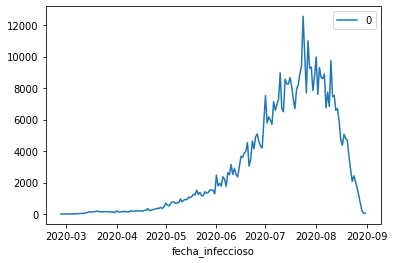

In [34]:
x = pd.DataFrame(dfCovid.groupby(['fecha_infeccioso']).size())
x.plot();

# Creacion de serie de tiempo de Casos Activos

Los casos activos por cada día equivalen son todos los casos del dataframe en el dia mencionado  menos los recuperados, menos los muertos.
Creamos un indice que incluyta todas las fechas en el intervalo de análisis. Para este detectamos la fecha inicial y final y usamos la funcion `np.arange`
Se agrega una caracteristica al dataframe que indica un intervalo de 7 días desde la fecha del primer contagio, esta caracteristica se usa para el modelo de predicción a mediano plazo.

In [47]:
import datetime

#Create an dataframe with all the dates in the interval
def CreateDates(str_date,df_covid):
  df_proc = df_covid.copy()
  #Create date indexes.
  dates = df_proc.groupby(str_date).count()
  date_init = dates.index[0]
  date_end = dates.index[-1]

  #Create an array with all days, one day is added to include boundaries
  all_days_arr = np.arange(date_init,date_end + datetime.timedelta(days=1))
  all_dates = pd.DataFrame(all_days_arr)
  all_dates['dias'] = np.arange(0,len(all_days_arr),step=1)

  #Calculate spans 7 days that will be assigned to each date. (feature used later for medium-term forecast model.)
  spans_count = np.int(np.ceil(len(all_days_arr)/7))
  spans = np.repeat(np.arange(0,spans_count),7)
  all_dates['semana'] = spans[0:len(all_days_arr)]
  
  print(date_init,"date init")
  print(date_end,"date end")
  all_dates.set_index(0,inplace=True)
  return all_dates

def GetActivos(dfCovid):
  df_proc = dfCovid.copy()
  dfActivos = CreateDates('fecha_infeccioso',df_proc)
  dfActivos['infectados'] = df_proc.groupby(['fecha_infeccioso']).count()['id_de_caso']
  dfActivos['recuperados'] = df_proc.groupby(['fecha_recuperado']).count()['id_de_caso']
  dfActivos['muertos'] = df_proc.groupby(['fecha_de_muerte']).count()['id_de_caso']
  dfActivos.fillna(0,inplace= True)
  dfActivos['acumulado_infectados']= dfActivos['infectados'].cumsum()
  dfActivos['acumulado_recuperados'] =  dfActivos['recuperados'].cumsum()
  dfActivos['acumulado_muertos'] =  dfActivos['muertos'].cumsum()
  dfActivos['activos']= dfActivos['acumulado_infectados'] - dfActivos['acumulado_recuperados'] - dfActivos['acumulado_muertos']
  dfActivos.index.rename("fecha_infeccioso",inplace=True)

  dfSemanales = dfActivos.groupby(['semana']).sum()[['infectados','recuperados','muertos']]
  dfSemanales['acumulado_infectados']= dfSemanales['infectados'].cumsum()
  dfSemanales['acumulado_recuperados'] =  dfSemanales['recuperados'].cumsum()
  dfSemanales['acumulado_muertos'] =  dfSemanales['muertos'].cumsum()
  dfSemanales['activos']= dfSemanales['acumulado_infectados'] - dfSemanales['acumulado_recuperados'] - dfSemanales['acumulado_muertos']

  return dfActivos, dfSemanales

#Generate two graphs with dayly facts and cumulated facts
def GraphData(label,dfActivos,dfSemanales = None):
  fig= plt.figure(figsize=(30,5))
  ax = plt.subplot(1,4,1)
  dfActivos[['infectados','recuperados','muertos']].plot(ax=ax)
  plt.title(label)
  ax = plt.subplot(1,4,2)
  dfActivos[['activos','acumulado_infectados']].plot(ax=ax)
  plt.title(label)
  if dfSemanales is not None:
    ax = plt.subplot(1,4,3)
    dfSemanales[['infectados','recuperados','muertos']].plot(ax=ax)
    plt.title('Semanal - {}'.format(label))
    ax = plt.subplot(1,4,4)
    dfSemanales[['activos','acumulado_infectados']].plot(ax=ax)
    plt.title('Semanal - {}'.format(label))

In [37]:
dfActivos,dfSemanales = GetActivos(dfCovid)
dfActivos

2020-02-27 date init
2020-08-31 date end


,dias,semana,infectados,recuperados,muertos,acumulado_infectados,acumulado_recuperados,acumulado_muertos,activos
fecha_infeccioso,,,,,,,,,
2020-02-27,0,0,1,0.0,0.0,1,0.0,0.0,1.0
2020-02-28,1,0,1,0.0,0.0,2,0.0,0.0,2.0
2020-02-29,2,0,2,0.0,0.0,4,0.0,0.0,4.0
2020-03-01,3,0,5,0.0,0.0,9,0.0,0.0,9.0
2020-03-02,4,0,4,0.0,0.0,13,0.0,0.0,13.0
...,...,...,...,...,...,...,...,...,...
2020-08-27,182,26,1170,10939.0,274.0,548359,417093.0,20537.0,110729.0
2020-08-28,183,26,670,12308.0,221.0,549029,429401.0,20758.0,98870.0
2020-08-29,184,26,197,11122.0,211.0,549226,440523.0,20969.0,87734.0


In [38]:
dfSemanales

,infectados,recuperados,muertos,acumulado_infectados,acumulado_recuperados,acumulado_muertos,activos
semana,,,,,,,
0,18,0.0,0.0,18,0.0,0.0,18.0
1,137,0.0,0.0,155,0.0,0.0,155.0
2,744,4.0,1.0,899,4.0,1.0,894.0
3,1088,39.0,7.0,1987,43.0,8.0,1936.0
4,970,191.0,25.0,2957,234.0,33.0,2690.0
5,1011,220.0,70.0,3968,454.0,103.0,3411.0
6,1318,513.0,69.0,5286,967.0,172.0,4147.0
7,1642,511.0,72.0,6928,1478.0,244.0,5206.0
8,2408,716.0,99.0,9336,2194.0,343.0,6799.0


In [39]:
dfActivos.to_pickle('Datos/data_{}.pickle'.format('Colombia'))
dfSemanales.to_pickle('Datos/data_weekly_{}.pickle'.format('Colombia'))

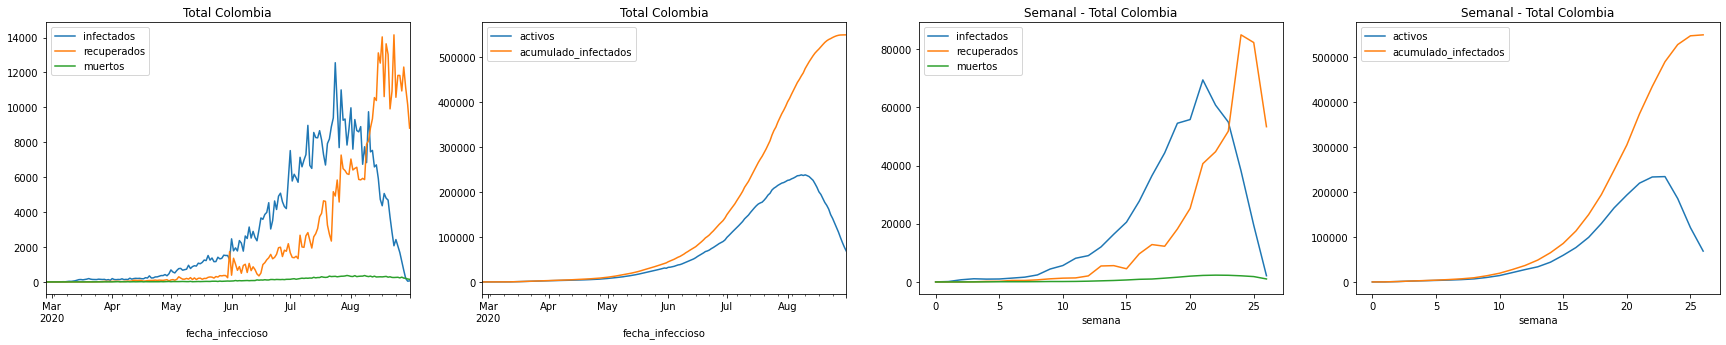

In [49]:
GraphData('Total Colombia',dfActivos,dfSemanales)

# Creacion de dataframes Ciudades
Se crean dataframes para las 5 ciudades de Colombia con mayor cantidad de habitantes.

In [50]:
ciudades = ['Bogotá D.C.','Medellín','Cali','Barranquilla', 'Cartagena de Indias']
names = ['Bogota','Medellin','Cali','Barranquilla','Cartagena']

In [51]:
#Remove old files
files = glob.glob('Datos/*')
for file in files:
  os.remove(file)

Bogotá D.C.
2020-02-27 date init
2020-08-31 date end
Medellín
2020-02-29 date init
2020-08-31 date end
Cali
2020-03-02 date init
2020-08-31 date end
Barranquilla
2020-03-06 date init
2020-08-31 date end
Cartagena de Indias
2020-03-01 date init
2020-08-31 date end


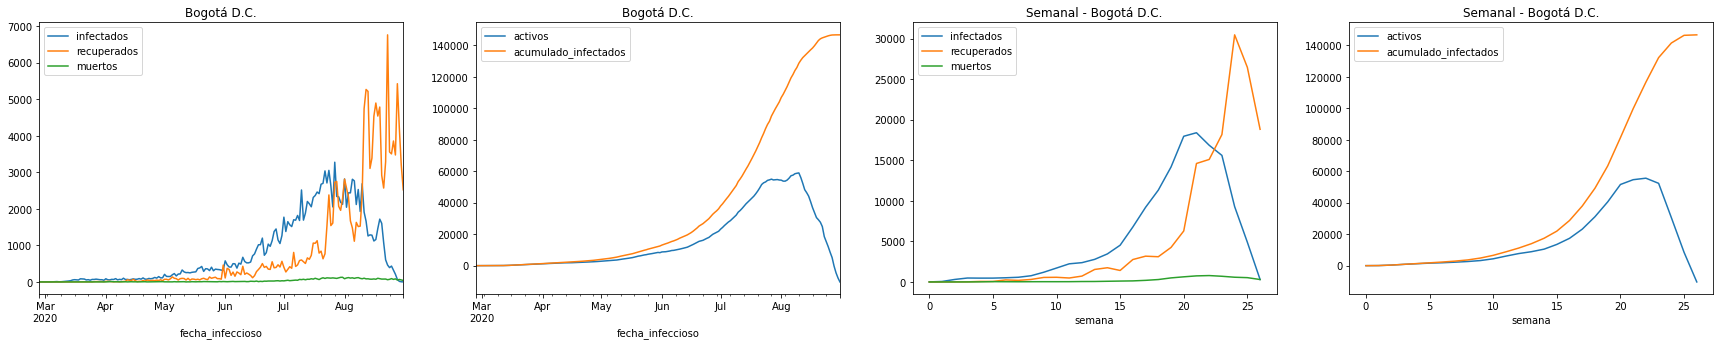

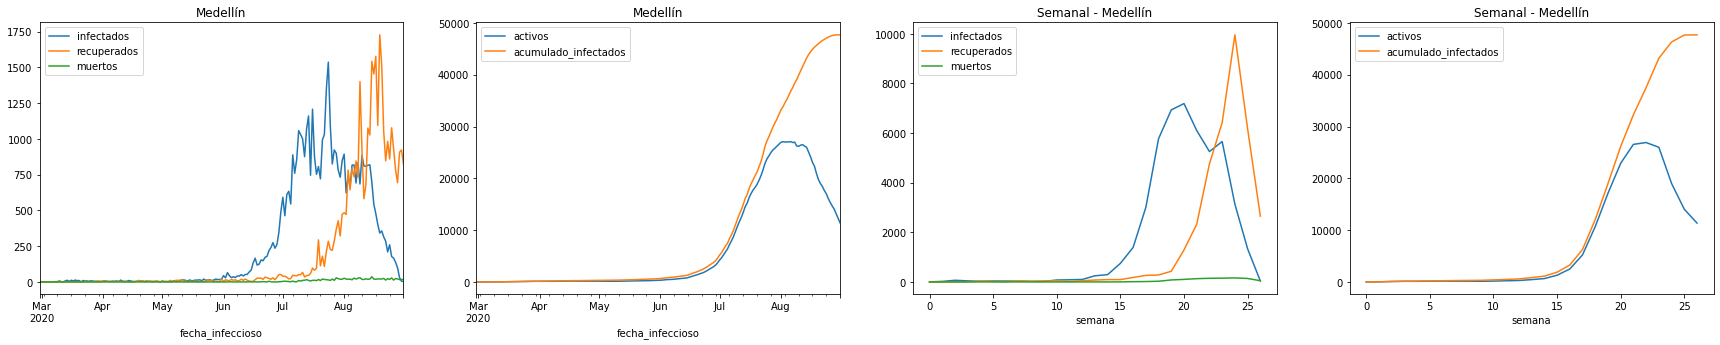

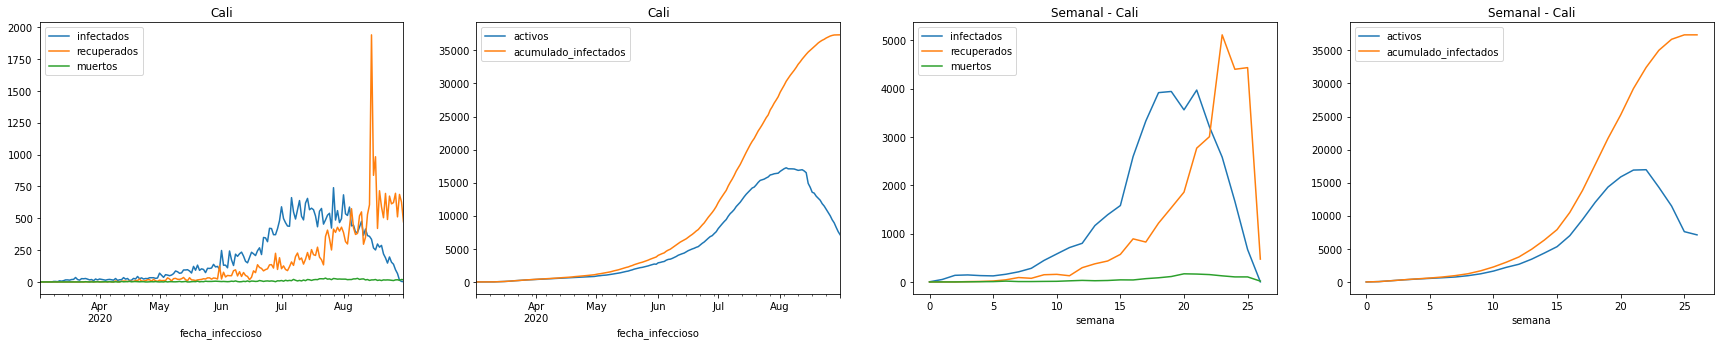

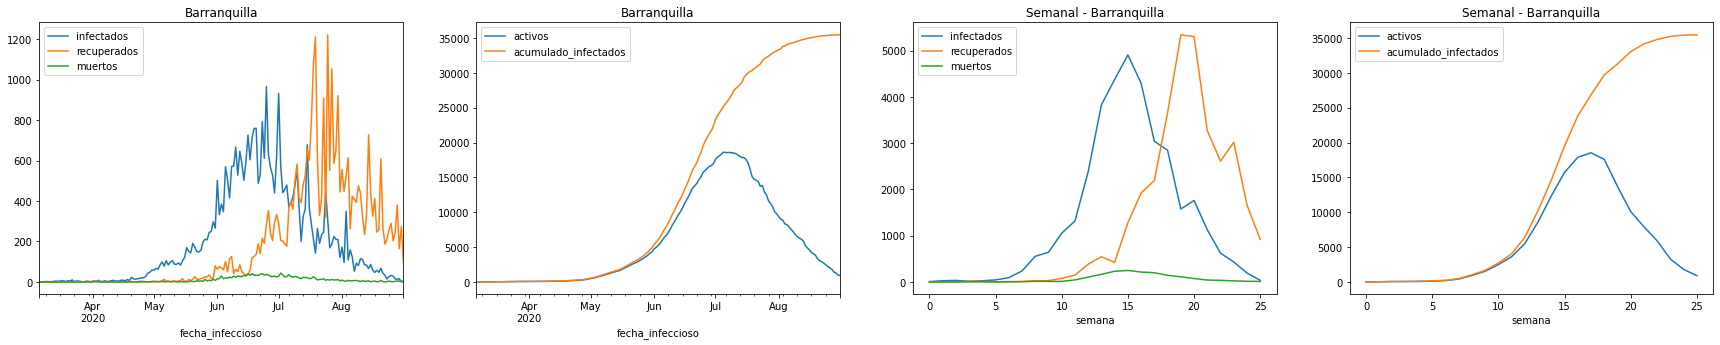

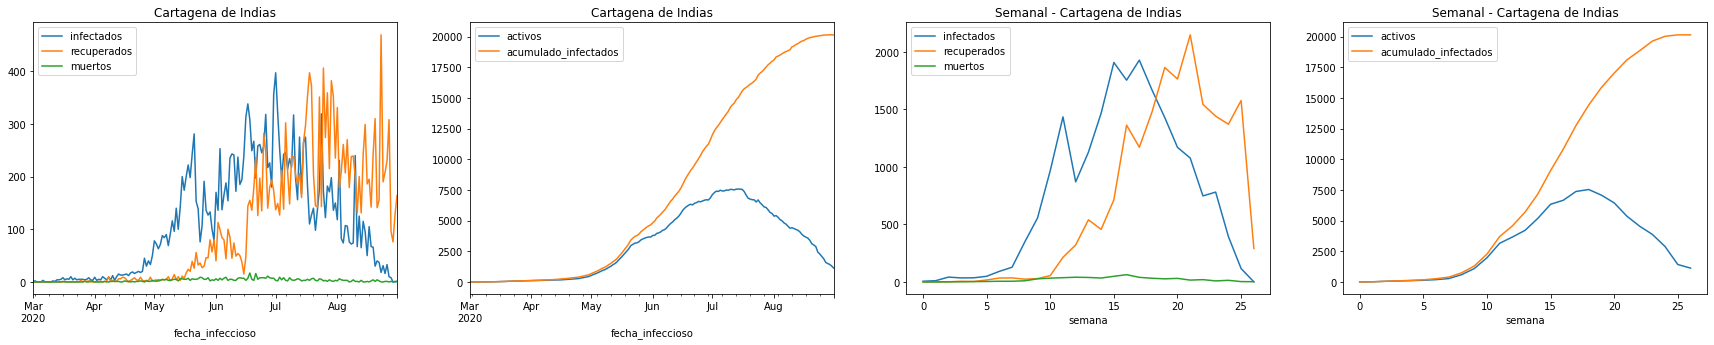

In [52]:
dfs=[]
#Remove old_data
for i in range(len(ciudades)):
  print(ciudades[i])
  df, dfw = GetActivos(dfCovid[(dfCovid['ciudad_de_ubicaci_n'] == ciudades[i])])
  #Save Picke file
  df.to_pickle('Datos/data_{}.pickle'.format(names[i]))
  dfw.to_pickle('Datos/data_weekly_{}.pickle'.format(names[i]))
  dfs.append(df)
  GraphData(ciudades[i],df,dfw)